##### Classification Dataset

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


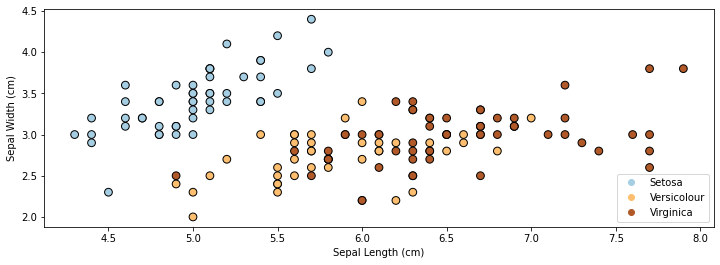

In [2]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

# create 2d version of dataset
X = iris_X.to_numpy()[:,:2]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Plot also the training points
p1 = plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica'], loc='lower right')


#### Discriminative Model
* Discriminative models directly partition the feature space into regions associated with each class and separated by a decision boundary.
* Given features 
, discriminative models directly map to predicted classes (e.g., via the function 
 for logistic regression).

Text(0, 0.5, 'Sepal width')

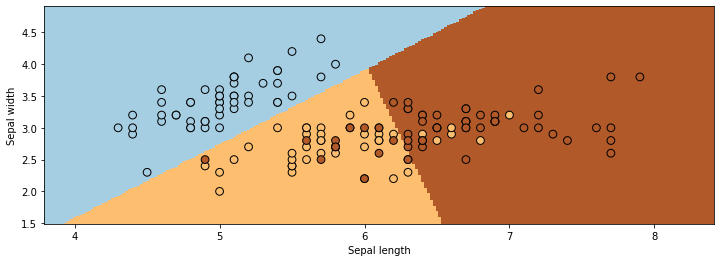

In [3]:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5, multi_class='multinomial')

# Create an instance of Softmax and fit the data.
logreg.fit(X, iris_y)
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

#### Generative Model
* In the Iris example, we first build a model of how each type of flower looks, i.e. we can learn the distributionIt defines a model of how each flower is generated, hence the name.

* Given a new flower datapoint , we can match it against each flower model and find the type of flower that looks most similar to it. Mathematically, this corresponds to:


#### Gaussian Discriminant model


In [9]:
# we can implement these formulas over the Iris dataset
d = 2 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X_k.T)
    phis[k] = X_k.shape[0] / float(n)

# print out the means
print(mus)

[[5.006 3.428]
 [5.936 2.77 ]
 [6.588 2.974]]


In [10]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)
print(idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 2 2
 2 1]


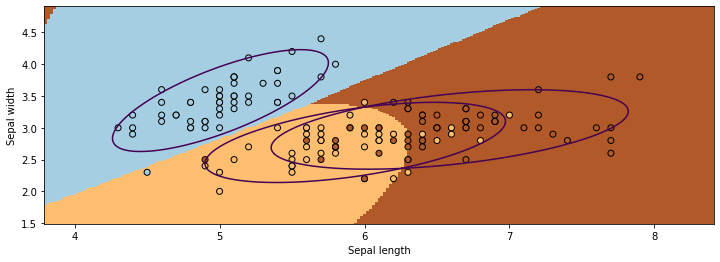

In [11]:
from matplotlib.colors import LogNorm
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K):
    contours[k] = logpy[k].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
for k in range(K):
    plt.contour(xx, yy, contours[k], levels=np.logspace(0, 1, 1))

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()